<a href="https://colab.research.google.com/github/santiagonajera/PlanificacionProduccion/blob/main/Forecast3500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# ===== CONFIGURATION =====
EXCEL_URL = "https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx"
SHEET_NAME = 'ITEMS'
TARGET_ITEM = 'ITEM-0001'  # Change this for different items
FORECAST_MONTHS = 10
# =========================

def load_and_prepare_data(url, sheet_name, item_name):
    """Load data from Excel and prepare time series"""
    df = pd.read_excel(url, sheet_name=sheet_name)

    # Transpose and clean the data
    item_data = df[df.iloc[:, 0] == item_name].iloc[:, 1:].T
    item_data.columns = ['sales']
    item_data = item_data.dropna()

    # Create proper datetime index
    dates = pd.date_range(start='2023-01', periods=len(item_data), freq='M')
    item_data.index = dates

    return item_data

def calculate_trend(series):
    """Calculate trend using moving average"""
    return series.rolling(window=12, min_periods=1, center=True).mean()

def calculate_seasonality(series, trend):
    """Calculate monthly seasonal factors"""
    # Get detrended series
    detrended = series / trend

    # Group by month and calculate average seasonal factors
    monthly_seasonal = detrended.groupby(detrended.index.month).mean()

    # Normalize to average 1.0
    monthly_seasonal = monthly_seasonal / monthly_seasonal.mean()

    return monthly_seasonal

def forecast_future(trend_series, seasonal_factors, periods):
    """Generate future forecast"""
    # Extend trend using linear regression on recent trend
    recent_trend = trend_series[-6:]  # Last 6 months for trend calculation
    x = np.arange(len(recent_trend))
    trend_coef = np.polyfit(x, recent_trend.values, 1)[0]

    # Generate future trend
    last_trend_value = trend_series.iloc[-1]
    future_trend = [last_trend_value + trend_coef * (i + 1) for i in range(periods)]

    # Generate future dates
    last_date = trend_series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                               periods=periods, freq='M')

    # Apply seasonality to trend
    future_forecast = []
    for i, date in enumerate(future_dates):
        month = date.month
        seasonal_factor = seasonal_factors[month]
        future_forecast.append(future_trend[i] * seasonal_factor)

    return pd.Series(future_forecast, index=future_dates)

def create_elegant_plot(historical, forecast, item_name):
    """Create professional visualization"""
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot historical data
    ax.plot(historical.index, historical.values,
            label='Ventas Históricas', linewidth=2.5, color='#2E86AB', marker='o', markersize=4)

    # Plot forecast
    ax.plot(forecast.index, forecast.values,
            label='Pronóstico', linewidth=2.5, color='#A23B72', linestyle='--', marker='s', markersize=4)

    # Customize the plot
    ax.set_title(f'Pronóstico de Ventas - {item_name}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
    ax.set_ylabel('Unidades Vendidas', fontsize=12, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Format ticks
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig

# ===== MAIN EXECUTION =====
try:
    # Load data
    print("Cargando datos...")
    sales_data = load_and_prepare_data(EXCEL_URL, SHEET_NAME, TARGET_ITEM)

    # Calculate components
    print("Calculando tendencia y estacionalidad...")
    trend = calculate_trend(sales_data['sales'])
    seasonal_factors = calculate_seasonality(sales_data['sales'], trend)

    # Generate forecast
    print("Generando pronóstico...")
    future_forecast = forecast_future(trend, seasonal_factors, FORECAST_MONTHS)

    # Create visualization
    print("Creando gráfica...")
    fig = create_elegant_plot(sales_data['sales'], future_forecast, TARGET_ITEM)
    plt.show()

    # Print results
    print(f"\n=== FACTORES ESTACIONALES MENSUALES ===")
    months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    for i, month in enumerate(months, 1):
        print(f"{month}: {seasonal_factors.get(i, 1.0):.3f}")

    print(f"\n=== PRONÓSTICO PRÓXIMOS {FORECAST_MONTHS} MESES ===")
    for date, value in future_forecast.items():
        print(f"{date.strftime('%b-%Y')}: {value:.0f} unidades")

except Exception as e:
    print(f"Error: {e}")
    print("Por favor verifica la URL y los nombres de pestaña/ítem")

Cargando datos...
Error: Length mismatch: Expected axis has 0 elements, new values have 1 elements
Por favor verifica la URL y los nombres de pestaña/ítem


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS')

# Procesar los datos
# La primera columna tiene los períodos, la segunda columna (B) tiene los valores
item_name = df.iloc[0, 1]  # Nombre del item
print(f"\nProcesando item: {item_name}")

# Extraer datos de ventas (desde la fila 2 en adelante, columna B)
data = []
dates = []

for i in range(2, len(df)):
    period = df.iloc[i, 0]
    value = df.iloc[i, 1]

    if pd.notna(period) and pd.notna(value):
        data.append(float(value))
        dates.append(str(period))

# Crear DataFrame con los datos históricos
historical_data = pd.DataFrame({
    'Periodo': dates,
    'Ventas': data
})

print(f"\nTotal de períodos históricos: {len(historical_data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

# Regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

# Crear un diccionario para agrupar por mes
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional (valor real / tendencia)
for i, periodo in enumerate(dates):
    mes = periodo.split('-')[0].lower()
    if mes in valores_por_mes:
        indice_estacional = data[i] / tendencia[i]
        valores_por_mes[mes].append(indice_estacional)

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
ultimo_mes, ultimo_anio = ultimo_periodo.split('-')
ultimo_anio = int('20' + ultimo_anio)

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, meses.index(ultimo_mes) + 1, 1)
fechas_forecast = []
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)
    fechas_forecast.append(nueva_fecha)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0]
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad[mes]
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, 'Inicio Forecast',
        rotation=90, verticalalignment='top', fontsize=10, color='gray')

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")

Leyendo archivo desde GitHub...

Procesando item: 503

Total de períodos históricos: 31
Rango de ventas: 458 - 803

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -1.16x + 634.23
R² = 0.0160

--- CALCULANDO ESTACIONALIDAD ---

Índices de Estacionalidad por mes:
ENE: 1.0000
FEB: 1.0000
MAR: 1.0000
ABR: 1.0000
MAY: 1.0000
JUN: 1.0000
JUL: 1.0000
AGO: 1.0000
SEP: 1.0000
OCT: 1.0000
NOV: 1.0000
DIC: 1.0000

--- GENERANDO FORECAST ---


ValueError: too many values to unpack (expected 2)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS')

# Procesar los datos
# Buscar la fila donde dice "ITEM" en la columna A
item_row = None
for i in range(len(df)):
    if pd.notna(df.iloc[i, 0]) and str(df.iloc[i, 0]).strip().upper() == 'ITEM':
        item_row = i
        break

if item_row is None:
    print("No se encontró la fila 'ITEM'")
    exit()

# El nombre del item está en la columna B de la fila donde dice "ITEM"
item_name = df.iloc[item_row, 1]
print(f"\nProcesando item: {item_name}")

# Extraer datos de ventas (desde la fila siguiente al item)
data = []
dates = []

for i in range(item_row + 1, len(df)):
    period = df.iloc[i, 0]
    value = df.iloc[i, 1]

    if pd.notna(period) and pd.notna(value):
        # Convertir período a string y limpiar
        period_str = str(period).strip()
        # Si el período tiene formato de fecha, convertirlo a "mes-año"
        if len(period_str) > 10:  # Probablemente un datetime
            try:
                fecha = pd.to_datetime(period)
                meses_esp = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
                            'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
                mes_nombre = meses_esp[fecha.month - 1]
                anio_corto = str(fecha.year)[2:]
                period_str = f"{mes_nombre}-{anio_corto}"
            except:
                pass

        data.append(float(value))
        dates.append(period_str)
    elif pd.notna(period) and str(period).strip().upper() == 'ITEM':
        # Si encontramos otro ITEM, terminamos
        break

# Crear DataFrame con los datos históricos
historical_data = pd.DataFrame({
    'Periodo': dates,
    'Ventas': data
})

# Verificar que tenemos datos suficientes
if len(data) < 12:
    print(f"\n⚠️  ADVERTENCIA: Solo se encontraron {len(data)} períodos. Se necesitan al menos 12 para calcular estacionalidad mensual.")

print(f"\nTotal de períodos históricos: {len(historical_data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"\nPrimeros períodos: {dates[:5]}")
print(f"Últimos períodos: {dates[-5:]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

# Regresión lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

# Crear un diccionario para agrupar por mes
meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional (valor real / tendencia)
for i, periodo in enumerate(dates):
    mes = periodo.split('-')[0].lower()
    if mes in valores_por_mes:
        indice_estacional = data[i] / tendencia[i]
        valores_por_mes[mes].append(indice_estacional)

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
# Manejar diferentes formatos de fecha
if '-' in ultimo_periodo:
    partes = ultimo_periodo.split('-')
    if len(partes) == 2:
        ultimo_mes, ultimo_anio = partes
        # Si el año es de 2 dígitos, convertir a 4
        if len(ultimo_anio) == 2:
            ultimo_anio = int('20' + ultimo_anio)
        else:
            ultimo_anio = int(ultimo_anio)
    else:
        # Formato diferente, usar el último valor
        print(f"Formato de fecha no reconocido: {ultimo_periodo}")
        # Asumir que es el último mes de los datos
        ultimo_mes = 'dic'
        ultimo_anio = 2024
else:
    ultimo_mes = 'dic'
    ultimo_anio = 2024

# Crear fechas para los próximos 10 meses
meses_dict = {'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12}

# Obtener el número del mes
if ultimo_mes.lower() in meses_dict:
    mes_num = meses_dict[ultimo_mes.lower()]
else:
    # Intentar convertir directamente si es un número
    try:
        mes_num = int(ultimo_mes)
    except:
        mes_num = 12  # Default a diciembre

fecha_inicio = datetime(ultimo_anio, mes_num, 1)
fechas_forecast = []
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)
    fechas_forecast.append(nueva_fecha)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    if mes in estacionalidad:
        forecast = tendencia_valor * estacionalidad[mes]
    else:
        forecast = tendencia_valor  # Sin estacionalidad si no se encuentra el mes
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, 'Inicio Forecast',
        rotation=90, verticalalignment='top', fontsize=10, color='gray')

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")

Leyendo archivo desde GitHub...
No se encontró la fila 'ITEM'


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Índices de Estacionalidad por mes:
ENE: 1.0000
FEB: 1.0000
MAR: 1.0000
ABR: 1.0000
MAY: 1.0000
JUN: 1.0000
JUL: 1.0000
AGO: 1.0000
SEP: 1.0000
OCT: 1.0000
NOV: 1.0000
DIC: 1.0000

--- GENERANDO FORECAST ---
Advertencia: No se pudo interpretar el último período: 2025-09-01 00:00:00

Forecast para los próximos 10 meses:
ene-25: 610
feb-25: 609
mar-25: 609
abr-25: 609
may-25: 609
jun-25: 609
jul-25: 609
ago-25: 608
sep-25: 608
oct-25: 608

--- GENERANDO GRÁFICA ---


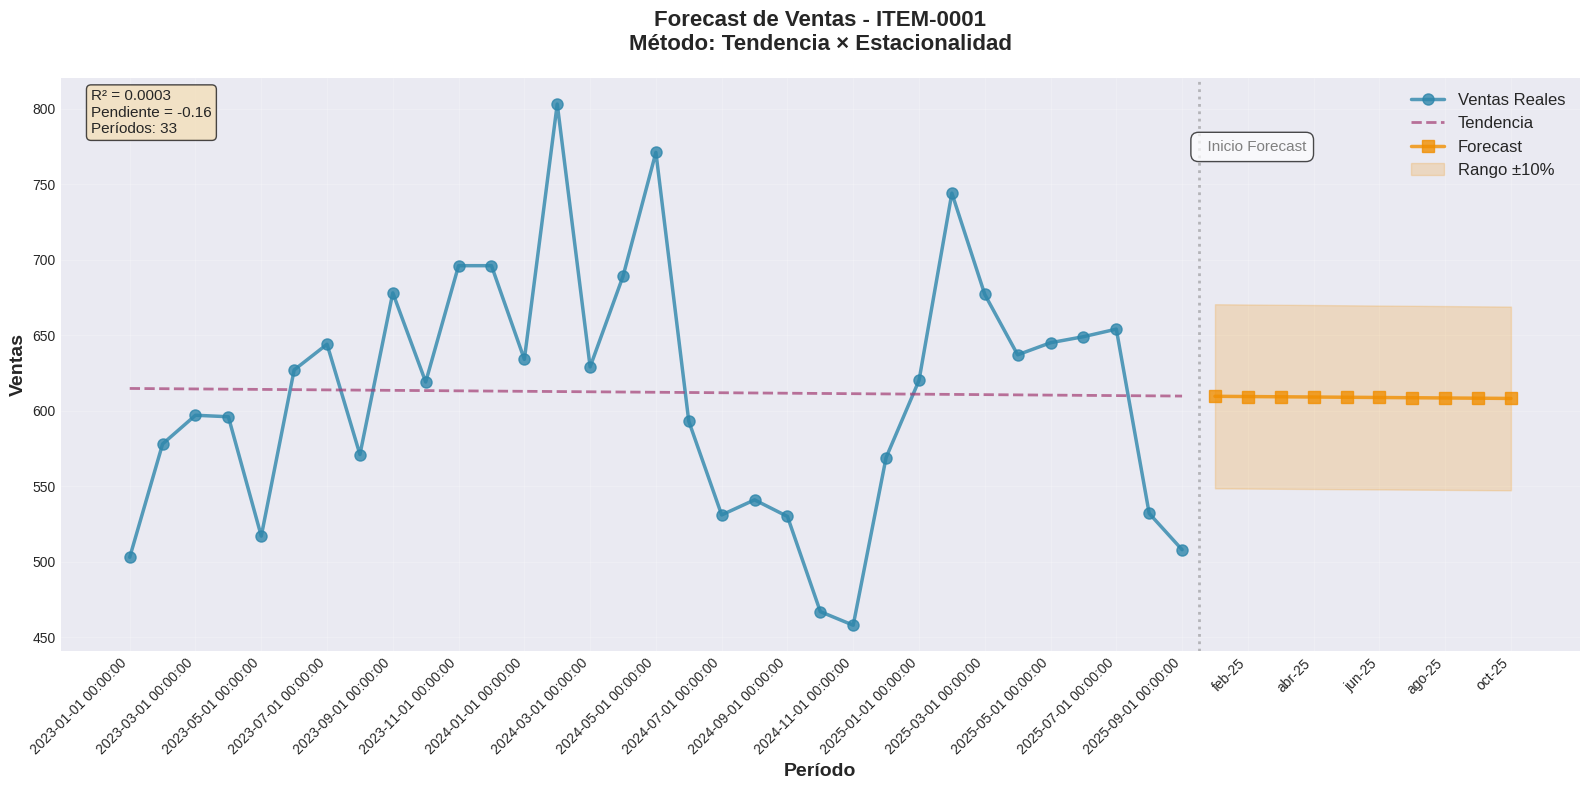


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

valores_por_mes = {mes: [] for mes in meses}

# Agrupar valores por mes y calcular índice estacional
for i, periodo in enumerate(dates):
    # Extraer el mes del período (formato: mes-año, ej: "ene-23")
    try:
        mes_parte = periodo.split('-')[0].lower()
        if mes_parte in valores_por_mes:
            # Índice estacional = valor real / valor de tendencia
            indice_estacional = data[i] / tendencia[i] if tendencia[i] != 0 else 1.0
            valores_por_mes[mes_parte].append(indice_estacional)
    except:
        continue

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f}")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Promedios anuales:

Índices de Estacionalidad por mes:
ENE: 1.0000 (basado en 0 observaciones)
FEB: 1.0000 (basado en 0 observaciones)
MAR: 1.0000 (basado en 0 observaciones)
ABR: 1.0000 (basado en 0 observaciones)
MAY: 1.0000 (basado en 0 observaciones)
JUN: 1.0000 (basado en 0 observaciones)
JUL: 1.0000 (basado en 0 observaciones)
AGO: 1.0000 (basado en 0 observaciones)
SEP: 1.0000 (basado en 0 observaciones)
OCT: 1.0000 (basado en 0 observaciones)
NOV: 1.0000 (basado en 0 observaciones)
DIC: 1.0000 (basado en 0 observaciones)

--- GENERANDO FORECAST ---
Advertencia: No se pudo interpretar el último período: 2025-09-01 00:00:00

Forecast para los próximos 10 meses:
ene-25: 610
feb-25: 609
ma

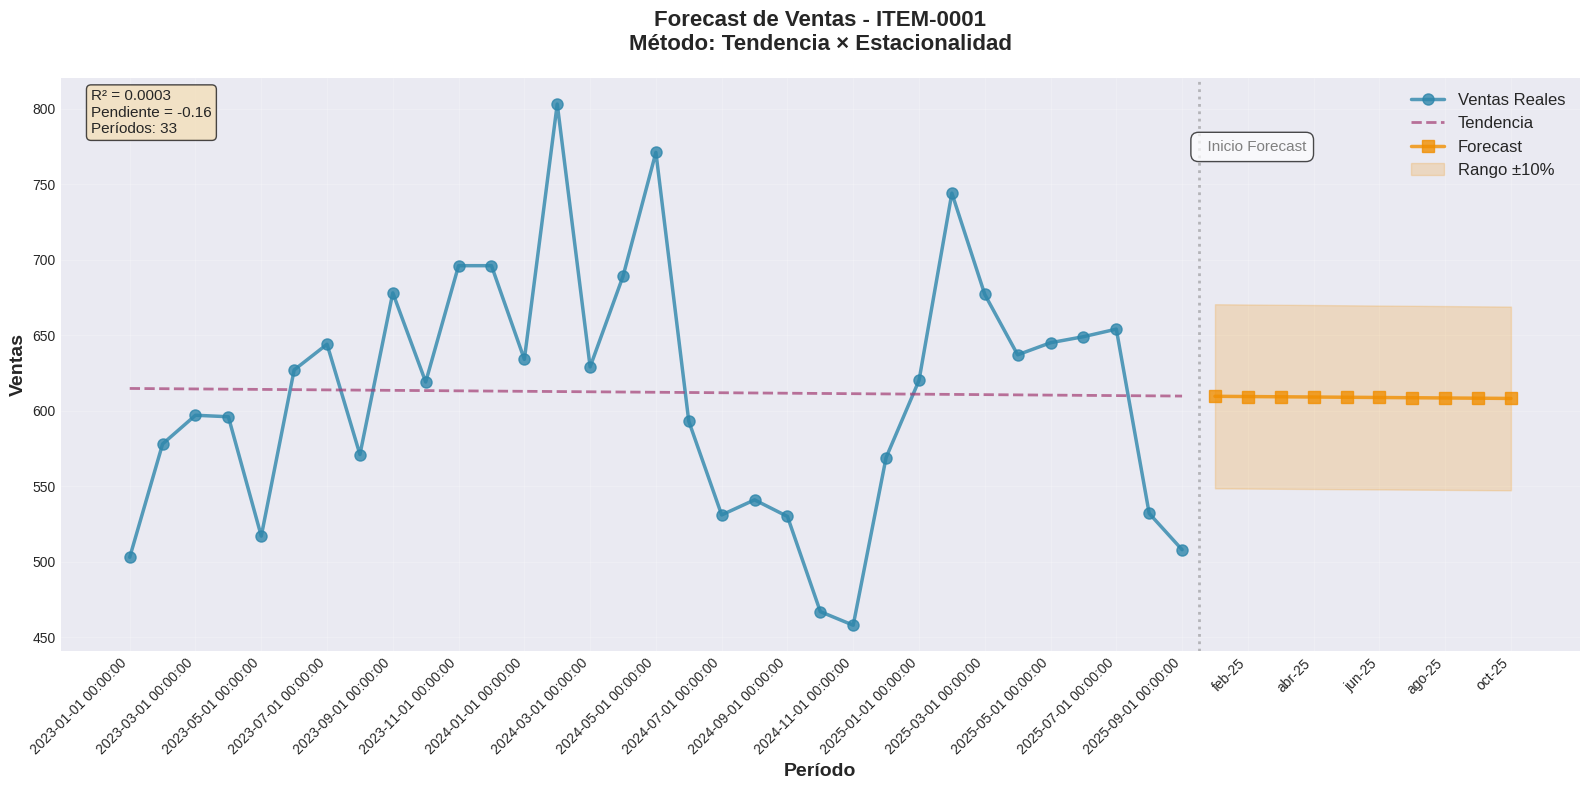


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    try:
        mes_parte, anio_parte = periodo.split('-')
        mes_parte = mes_parte.lower()

        # Convertir año a formato completo
        if len(anio_parte) == 2:
            anio_completo = '20' + anio_parte
        else:
            anio_completo = anio_parte

        # Agrupar por año
        if anio_completo not in datos_por_anio:
            datos_por_anio[anio_completo] = []
        datos_por_anio[anio_completo].append(data[i])
    except:
        continue

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

for i, periodo in enumerate(dates):
    try:
        mes_parte, anio_parte = periodo.split('-')
        mes_parte = mes_parte.lower()

        # Convertir año a formato completo
        if len(anio_parte) == 2:
            anio_completo = '20' + anio_parte
        else:
            anio_completo = anio_parte

        if mes_parte in valores_por_mes and anio_completo in promedio_por_anio:
            # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
            indice_estacional = data[i] / promedio_por_anio[anio_completo]
            valores_por_mes[mes_parte].append(indice_estacional)
    except:
        continue

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (basado en {observaciones} observaciones)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...

Procesando item: ITEM-0001

Total de períodos históricos: 33
Rango de ventas: 458 - 803
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -0.16x + 614.73
R² = 0.0003

--- CALCULANDO ESTACIONALIDAD ---

Muestra de períodos detectados:
  2023-01-01 00:00:00 -> Mes: ene, Año: 2023
  2023-02-01 00:00:00 -> Mes: feb, Año: 2023
  2023-03-01 00:00:00 -> Mes: mar, Año: 2023
  2023-04-01 00:00:00 -> Mes: abr, Año: 2023
  2023-05-01 00:00:00 -> Mes: may, Año: 2023

Promedios anuales:
Año 2023: 610.17 (basado en 12 meses)
Año 2024: 601.25 (basado en 12 meses)
Año 2025: 629.56 (basado en 9 meses)

Detalle del cálculo de estacionalidad:
  2023-01-01 00:00:00: 503 / 610.17 = 0.8244 (82%)
  2023-02-01 00:00:00: 578 / 610.17 = 0.9473 (95%)
  2023-03-01 00:00:00: 597 / 610.17 = 0.9784 (98%)

Índices de Estacionalidad por mes:
ENE: 0.9546 (95%) - basado en 3 observaciones
FEB: 1.1549 (115%) - basado en 3 obse

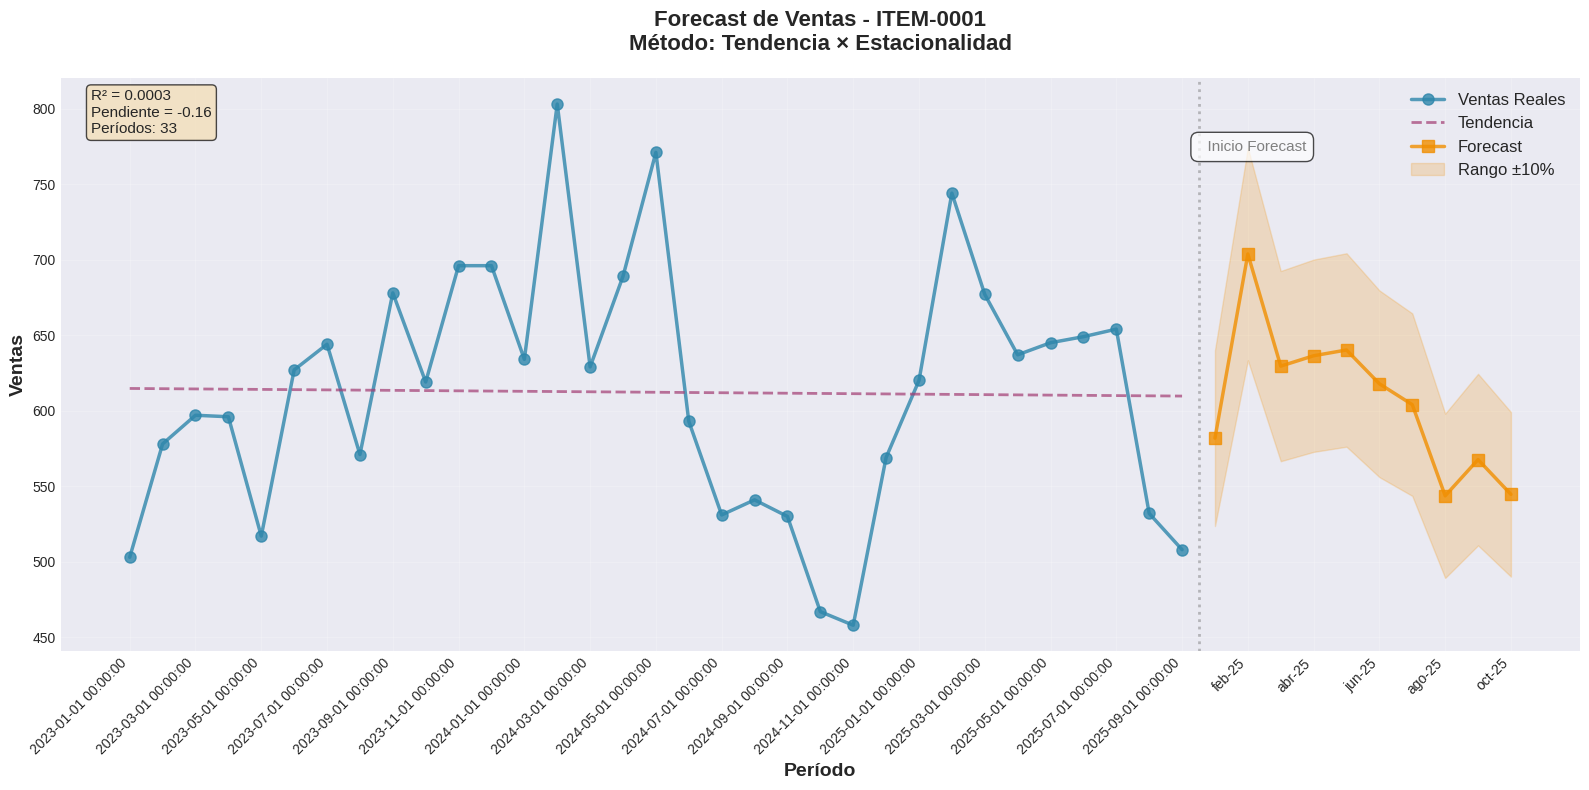


✓ Proceso completado exitosamente!

Resumen:
- Item analizado: ITEM-0001
- Períodos históricos: 33
- Tendencia: Decreciente
- R²: 0.0003
- Forecast generado: 10 meses


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# Leer el archivo Excel sin encabezados
print("Leyendo archivo desde GitHub...")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la columna que contiene "ITEM" en alguna fila
item_col = None
item_row = None

for col in range(df.shape[1]):
    for row in range(min(10, df.shape[0])):
        val = df.iloc[row, col]
        if pd.notna(val) and str(val).strip().upper() == 'ITEM':
            item_col = col
            item_row = row
            break
    if item_col is not None:
        break

if item_col is None:
    print("ERROR: No se encontró la columna con 'ITEM'")
    print("\nPrimeras filas del archivo:")
    print(df.head(10))
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'A', 'B', 'C', ..., 'X', 'Y', 'Z', etc.
COLUMNA_ITEM = 'X'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la fila que contiene "ITEM" en la columna seleccionada
item_row = None

for row in range(min(10, df.shape[0])):
    val = df.iloc[row, item_col]
    if pd.notna(val) and str(val).strip().upper() == 'ITEM':
        item_row = row
        break

if item_row is None:
    print(f"ERROR: No se encontró 'ITEM' en la columna {COLUMNA_ITEM}")
    print(f"\nPrimeras filas de la columna {COLUMNA_ITEM}:")
    print(df.iloc[:10, item_col])
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Los períodos están en la columna del ITEM, comenzando desde la fila siguiente
# Los valores están en la columna siguiente (donde está el nombre del item)
data = []
dates = []

for i in range(item_row + 1, df.shape[0]):
    period = df.iloc[i, item_col]
    value = df.iloc[i, item_col + 1]

    if pd.notna(period) and pd.notna(value):
        try:
            # Verificar si encontramos otro ITEM (inicio de otro producto)
            if str(period).strip().upper() == 'ITEM':
                break

            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    else:
        # Si hay filas vacías, verificar si es fin de datos
        if len(data) > 0:
            break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...
Analizando item en columna: X (índice 23)
ERROR: No se encontró 'ITEM' en la columna X

Primeras filas de la columna X:
0    ITEM-0023
1          546
2          593
3          775
4          593
5          618
6          654
7          708
8          532
9          546
Name: 23, dtype: object


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'A', 'B', 'C', ..., 'X', 'Y', 'Z', etc.
COLUMNA_ITEM = 'X'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Buscar la fila que contiene "ITEM" en la columna seleccionada
item_row = None

for row in range(min(10, df.shape[0])):
    val = df.iloc[row, item_col]
    if pd.notna(val) and str(val).strip().upper() == 'ITEM':
        item_row = row
        break

if item_row is None:
    print(f"ERROR: No se encontró 'ITEM' en la columna {COLUMNA_ITEM}")
    print(f"\nPrimeras filas de la columna {COLUMNA_ITEM}:")
    print(df.iloc[:10, item_col])
    exit()

# El nombre del item está en la siguiente columna (columna B si ITEM está en A)
item_name = df.iloc[item_row, item_col + 1]
print(f"\nProcesando item: {item_name}")

# Extraer períodos y ventas
# Fila 0: encabezados (ITEM, ITEM-0001, ITEM-0002, etc.)
# Fila 1 en adelante: fechas en columna A, valores en las demás columnas
data = []
dates = []

for i in range(1, df.shape[0]):  # Empezar desde fila 1 (fila 0 son encabezados)
    period = df.iloc[i, fecha_col]  # Fecha en columna A
    value = df.iloc[i, item_col]    # Valor en la columna del item

    if pd.notna(period) and pd.notna(value):
        try:
            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, probablemente terminaron los datos
            break
    elif pd.notna(period):
        # Si hay fecha pero no valor, seguir (puede haber celdas vacías)
        continue
    else:
        # Si no hay fecha, terminaron los datos
        break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_idx, mes_nombre in enumerate(meses):
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        # Agrupar por año
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad:")
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if i < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - basado en {observaciones} observaciones")
    else:
        print(f"{mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"{row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"- Item analizado: {item_name}")
print(f"- Períodos históricos: {len(data)}")
print(f"- Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"- R²: {r_value**2:.4f}")
print(f"- Forecast generado: {len(forecast_values)} meses")

Leyendo archivo desde GitHub...
Analizando item en columna: X (índice 23)
ERROR: No se encontró 'ITEM' en la columna X

Primeras filas de la columna X:
0    ITEM-0023
1          546
2          593
3          775
4          593
5          618
6          654
7          708
8          532
9          546
Name: 23, dtype: object


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

Leyendo archivo desde GitHub...
Analizando item en columna: AB (índice 27)

Procesando item: ITEM-0027

Total de períodos históricos: 33
Rango de ventas: 230 - 742
Períodos: 2023-01-01 00:00:00 hasta 2025-09-01 00:00:00

--- CALCULANDO TENDENCIA ---
Ecuación de tendencia: y = -2.90x + 506.22
R² = 0.0359

--- CALCULANDO ESTACIONALIDAD ---

Muestra de períodos detectados:
  2023-01-01 00:00:00 -> Mes: ene, Año: 2023
  2023-02-01 00:00:00 -> Mes: feb, Año: 2023
  2023-03-01 00:00:00 -> Mes: mar, Año: 2023
  2023-04-01 00:00:00 -> Mes: abr, Año: 2023
  2023-05-01 00:00:00 -> Mes: may, Año: 2023

Promedios anuales:
  Año 2023: 471.67 (basado en 12 meses)
  Año 2024: 460.58 (basado en 12 meses)
  Año 2025: 443.11 (basado en 9 meses)

Detalle del cálculo de estacionalidad (primeros 3):
  2023-01-01 00:00:00: 673 / 471.67 = 1.4269 (143%)
  2023-02-01 00:00:00: 625 / 471.67 = 1.3251 (133%)
  2023-03-01 00:00:00: 713 / 471.67 = 1.5117 (151%)

Índices de Estacionalidad por mes:
  ENE: 1.5339 (153

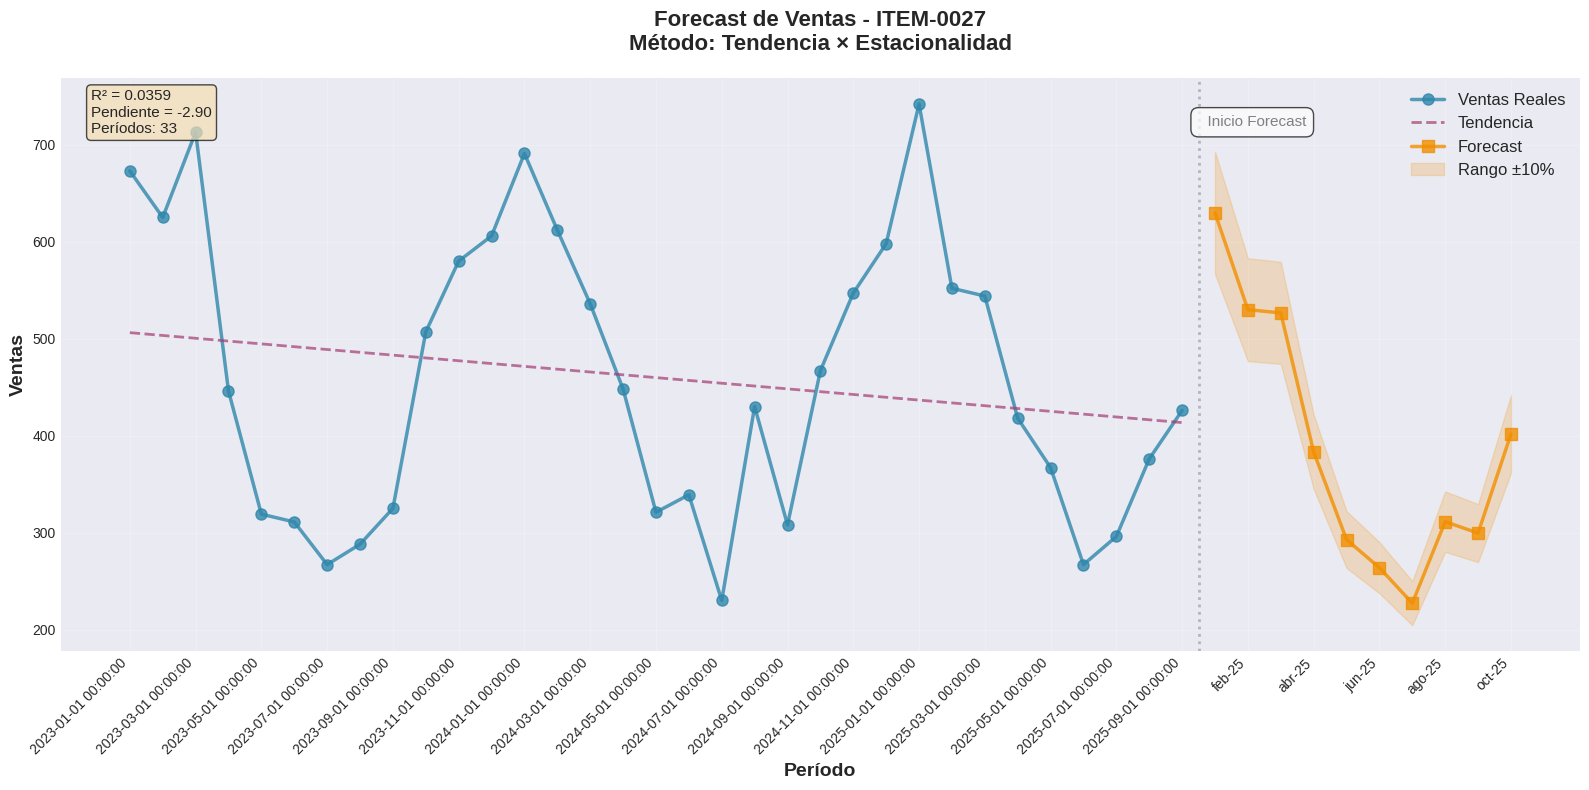


✓ Proceso completado exitosamente!

Resumen:
  - Item analizado: ITEM-0027
  - Columna: AB
  - Períodos históricos: 33
  - Tendencia: Decreciente
  - R²: 0.0359
  - Forecast generado: 10 meses


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficas elegantes
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# URL del archivo
url = 'https://github.com/santiagonajera/PlanificacionProduccion/raw/refs/heads/main/ventas_mensuales_3500_items_2023_2025.xlsx'

# ==========================================
# CONFIGURACIÓN: Selecciona la columna del item a analizar
# ==========================================
# Opciones: 'B', 'C', 'D', ..., 'X', 'Y', 'Z', etc.
# (La columna A contiene las fechas, no un item)
COLUMNA_ITEM = 'AB'  # <-- CAMBIA ESTA LETRA PARA ANALIZAR OTRO ITEM
# ==========================================

# Convertir letra de columna a índice numérico (A=0, B=1, X=23, etc.)
def columna_a_indice(letra):
    """Convierte letra de columna a índice (A=0, B=1, etc.)"""
    letra = letra.upper()
    indice = 0
    for i, char in enumerate(reversed(letra)):
        indice += (ord(char) - ord('A') + 1) * (26 ** i)
    return indice - 1

item_col = columna_a_indice(COLUMNA_ITEM)
fecha_col = 0  # La columna A (índice 0) siempre tiene las fechas

# Leer el archivo Excel sin encabezados
print(f"Leyendo archivo desde GitHub...")
print(f"Analizando item en columna: {COLUMNA_ITEM} (índice {item_col})\n")
df = pd.read_excel(url, sheet_name='ITEMS', header=None)

# Verificar que la columna existe
if item_col >= df.shape[1]:
    print(f"ERROR: La columna {COLUMNA_ITEM} no existe en el archivo")
    print(f"El archivo tiene {df.shape[1]} columnas (A hasta {chr(65 + df.shape[1] - 1)})")
    exit()

# La fila 0 contiene los encabezados
# Columna A debe tener "ITEM"
# Las demás columnas tienen los códigos de items (ej: "ITEM-0023")
item_name = df.iloc[0, item_col]

if pd.isna(item_name):
    print(f"ERROR: La columna {COLUMNA_ITEM} no tiene un código de item en la fila 0")
    exit()

print(f"Procesando item: {item_name}")

# Extraer períodos y ventas
# Fila 0: encabezados (ITEM en col A, ITEM-0001 en col B, etc.)
# Fila 1 en adelante: fechas en columna A, valores en las demás columnas
data = []
dates = []

for i in range(1, df.shape[0]):  # Empezar desde fila 1
    period = df.iloc[i, fecha_col]  # Fecha en columna A (índice 0)
    value = df.iloc[i, item_col]    # Valor en la columna del item

    if pd.notna(period) and pd.notna(value):
        try:
            period_str = str(period).strip()
            value_num = float(value)

            dates.append(period_str)
            data.append(value_num)
        except:
            # Si hay error al convertir, seguir o terminar
            continue
    elif not pd.notna(period):
        # Si no hay fecha, terminaron los datos
        break

if len(data) == 0:
    print("ERROR: No se encontraron datos de ventas")
    exit()

print(f"\nTotal de períodos históricos: {len(data)}")
print(f"Rango de ventas: {min(data):.0f} - {max(data):.0f}")
print(f"Períodos: {dates[0]} hasta {dates[-1]}")

# 1. CALCULAR LA TENDENCIA (usando regresión lineal)
print("\n--- CALCULANDO TENDENCIA ---")
x = np.arange(len(data))
y = np.array(data)

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
tendencia = slope * x + intercept

print(f"Ecuación de tendencia: y = {slope:.2f}x + {intercept:.2f}")
print(f"R² = {r_value**2:.4f}")

# 2. CALCULAR LA ESTACIONALIDAD MENSUAL
print("\n--- CALCULANDO ESTACIONALIDAD ---")

meses = ['ene', 'feb', 'mar', 'abr', 'may', 'jun',
         'jul', 'ago', 'sep', 'oct', 'nov', 'dic']

# Función para extraer mes y año del período
def extraer_mes_anio(periodo_str):
    """Extrae el mes y año de diferentes formatos de período"""
    periodo_str = str(periodo_str).strip().lower()

    # Intentar formato "mes-año" (ej: "ene-23", "enero-2023")
    if '-' in periodo_str:
        partes = periodo_str.split('-')
        mes_str = partes[0].strip()
        anio_str = partes[1].strip()

        # Buscar el mes en la lista
        for mes_nombre in meses:
            if mes_str.startswith(mes_nombre[:3]):
                # Convertir año a formato completo
                if len(anio_str) == 2:
                    anio = '20' + anio_str
                else:
                    anio = anio_str
                return mes_nombre, anio

    # Si es un objeto datetime de pandas
    try:
        fecha = pd.to_datetime(periodo_str)
        mes_nombre = meses[fecha.month - 1]
        anio = str(fecha.year)
        return mes_nombre, anio
    except:
        pass

    return None, None

print("\nMuestra de períodos detectados:")
for i in range(min(5, len(dates))):
    mes, anio = extraer_mes_anio(dates[i])
    print(f"  {dates[i]} -> Mes: {mes}, Año: {anio}")

# Primero, agrupar los datos por año y calcular el promedio de cada año
datos_por_anio = {}

for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio:
        if anio not in datos_por_anio:
            datos_por_anio[anio] = []
        datos_por_anio[anio].append(data[i])

# Calcular el promedio de cada año
promedio_por_anio = {}
print("\nPromedios anuales:")
for anio in sorted(datos_por_anio.keys()):
    promedio_por_anio[anio] = np.mean(datos_por_anio[anio])
    print(f"  Año {anio}: {promedio_por_anio[anio]:.2f} (basado en {len(datos_por_anio[anio])} meses)")

# Calcular índice estacional: demanda del mes / promedio del año
valores_por_mes = {mes: [] for mes in meses}

print("\nDetalle del cálculo de estacionalidad (primeros 3):")
count = 0
for i, periodo in enumerate(dates):
    mes, anio = extraer_mes_anio(periodo)
    if mes and anio and anio in promedio_por_anio:
        # ÍNDICE ESTACIONAL = demanda del mes / promedio anual
        indice_estacional = data[i] / promedio_por_anio[anio]
        valores_por_mes[mes].append(indice_estacional)

        # Mostrar primeros 3 ejemplos
        if count < 3:
            print(f"  {periodo}: {data[i]:.0f} / {promedio_por_anio[anio]:.2f} = {indice_estacional:.4f} ({indice_estacional*100:.0f}%)")
            count += 1

# Calcular el índice promedio de estacionalidad para cada mes
estacionalidad = {}
for mes in meses:
    if valores_por_mes[mes]:
        estacionalidad[mes] = np.mean(valores_por_mes[mes])
    else:
        estacionalidad[mes] = 1.0

print("\nÍndices de Estacionalidad por mes:")
for mes in meses:
    observaciones = len(valores_por_mes[mes])
    if observaciones > 0:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} ({estacionalidad[mes]*100:.0f}%) - {observaciones} obs")
    else:
        print(f"  {mes.upper()}: {estacionalidad[mes]:.4f} (sin datos)")

# 3. GENERAR FORECAST PARA LOS PRÓXIMOS 10 MESES
print("\n--- GENERANDO FORECAST ---")

# Determinar el último período
ultimo_periodo = dates[-1]
try:
    ultimo_mes_str, ultimo_anio_str = ultimo_periodo.split('-')
    ultimo_mes_str = ultimo_mes_str.lower()

    # Convertir año a 4 dígitos
    if len(ultimo_anio_str) == 2:
        ultimo_anio = int('20' + ultimo_anio_str)
    else:
        ultimo_anio = int(ultimo_anio_str)

    # Obtener número del mes
    if ultimo_mes_str in meses:
        ultimo_mes_num = meses.index(ultimo_mes_str) + 1
    else:
        ultimo_mes_num = 12

except:
    print(f"Advertencia: No se pudo interpretar el último período: {ultimo_periodo}")
    ultimo_anio = 2024
    ultimo_mes_num = 12

# Crear fechas para los próximos 10 meses
fecha_inicio = datetime(ultimo_anio, ultimo_mes_num, 1)
periodos_forecast = []

for i in range(1, 11):
    nueva_fecha = fecha_inicio + relativedelta(months=i)
    mes_nombre = meses[nueva_fecha.month - 1]
    anio_corto = str(nueva_fecha.year)[2:]
    periodo = f"{mes_nombre}-{anio_corto}"
    periodos_forecast.append(periodo)

# Calcular forecast = Tendencia * Estacionalidad
forecast_values = []
for i, periodo in enumerate(periodos_forecast):
    mes = periodo.split('-')[0].lower()
    # Índice para la tendencia (continuación de la serie)
    x_forecast = len(data) + i
    tendencia_valor = slope * x_forecast + intercept
    # Aplicar estacionalidad
    forecast = tendencia_valor * estacionalidad.get(mes, 1.0)
    forecast_values.append(forecast)

# Crear DataFrame con forecast
df_forecast = pd.DataFrame({
    'Periodo': periodos_forecast,
    'Forecast': forecast_values
})

print("\nForecast para los próximos 10 meses:")
for i, row in df_forecast.iterrows():
    print(f"  {row['Periodo']}: {row['Forecast']:.0f}")

# 4. CREAR GRÁFICA ELEGANTE
print("\n--- GENERANDO GRÁFICA ---")

fig, ax = plt.subplots(figsize=(16, 8))

# Crear eje x continuo
x_historical = np.arange(len(data))
x_forecast = np.arange(len(data), len(data) + len(forecast_values))

# Graficar datos históricos
ax.plot(x_historical, data, 'o-', linewidth=2.5, markersize=8,
        label='Ventas Reales', color='#2E86AB', alpha=0.8)

# Graficar tendencia
ax.plot(x_historical, tendencia, '--', linewidth=2,
        label='Tendencia', color='#A23B72', alpha=0.7)

# Graficar forecast
ax.plot(x_forecast, forecast_values, 's-', linewidth=2.5, markersize=8,
        label='Forecast', color='#F18F01', alpha=0.8)

# Área sombreada para el forecast (intervalo de confianza visual)
ax.fill_between(x_forecast,
                np.array(forecast_values) * 0.9,
                np.array(forecast_values) * 1.1,
                alpha=0.2, color='#F18F01', label='Rango ±10%')

# Añadir línea vertical separando histórico de forecast
ax.axvline(x=len(data)-0.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
ax.text(len(data)-0.5, ax.get_ylim()[1]*0.95, '  Inicio Forecast',
        rotation=0, verticalalignment='top', fontsize=11, color='gray',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

# Configuración de la gráfica
ax.set_xlabel('Período', fontsize=14, fontweight='bold')
ax.set_ylabel('Ventas', fontsize=14, fontweight='bold')
ax.set_title(f'Forecast de Ventas - {item_name}\nMétodo: Tendencia × Estacionalidad',
             fontsize=16, fontweight='bold', pad=20)

# Configurar etiquetas del eje x
todos_periodos = dates + periodos_forecast
x_ticks = list(range(0, len(todos_periodos), max(1, len(todos_periodos)//15)))
ax.set_xticks(x_ticks)
ax.set_xticklabels([todos_periodos[i] for i in x_ticks], rotation=45, ha='right')

# Grid y leyenda
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.legend(loc='best', fontsize=12, framealpha=0.9, shadow=True)

# Añadir información adicional
textstr = f'R² = {r_value**2:.4f}\nPendiente = {slope:.2f}\nPeríodos: {len(data)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n✓ Proceso completado exitosamente!")
print(f"\nResumen:")
print(f"  - Item analizado: {item_name}")
print(f"  - Columna: {COLUMNA_ITEM}")
print(f"  - Períodos históricos: {len(data)}")
print(f"  - Tendencia: {'Creciente' if slope > 0 else 'Decreciente'}")
print(f"  - R²: {r_value**2:.4f}")
print(f"  - Forecast generado: {len(forecast_values)} meses")